In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

In [95]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [96]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all_3_6=data_all[data_all['COT']<3.6]
data_all_10=data_all[data_all['COT']<10]
data_all_25=data_all[data_all['COT']<25]

#data_all=hf.add_MSI_noise(data_all,channel_labels)

(array([ 1004.,   397.,   785.,   645.,   891.,  1942.,  2682.,  3837.,
         8766., 29051.]),
 array([0.04146 , 0.135098, 0.228736, 0.322374, 0.416012, 0.50965 ,
        0.603288, 0.696926, 0.790564, 0.884202, 0.97784 ]),
 <BarContainer object of 10 artists>)

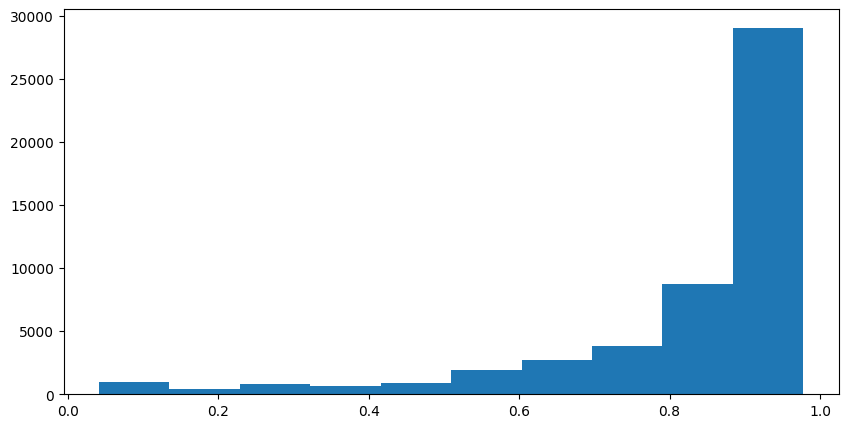

In [136]:
plt.hist(data_mixed['Clear_B12'])

In [97]:
print("Number of data points for 3.6 limit: "+str(len(data_all_3_6)))
print("Number of data points for 10 limit: "+str(len(data_all_10)))
print("Number of data points for 25 limit: "+str(len(data_all_25)))
print("Number of data points for no limit: "+str(len(data_all)))

Number of data points for 3.6 limit: 21786
Number of data points for 10 limit: 53156
Number of data points for 25 limit: 102006
Number of data points for no limit: 150000


In [98]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B12']

X_truth=df_truth[X_labels]

df=data_all.copy()
#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X_3_6=data_all_3_6[X_labels]
y_3_6=data_all_3_6[y_labels]

X_10=data_all_10[X_labels]
y_10=data_all_10[y_labels]

X_25=data_all_25[X_labels]
y_25=data_all_25[y_labels]

X=df[X_labels]
y=df[y_labels]

X_train_3_6, X_test_3_6, y_train_3_6, y_test_3_6=train_test_split(X_3_6,y_3_6,test_size=0.05)
X_train_10, X_test_10, y_train_10, y_test_10=train_test_split(X_10,y_10,test_size=0.05)
X_train_25, X_test_25, y_train_25, y_test_25=train_test_split(X_25,y_25,test_size=0.05)
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [99]:
import random

val_size=0.05
validation_indices_3_6=np.array(random.sample(range(len(X_train_3_6['Cloud_B02'])), int(len(X_train_3_6['Cloud_B02'])*val_size)))
train_indices_3_6=[i for i in range(len(X_train_3_6['Cloud_B02'])) if np.any(validation_indices_3_6==i)==False]

validation_indices_10=np.array(random.sample(range(len(X_train_10['Cloud_B02'])), int(len(X_train_10['Cloud_B02'])*val_size)))
train_indices_10=[i for i in range(len(X_train_10['Cloud_B02'])) if np.any(validation_indices_10==i)==False]

validation_indices_25=np.array(random.sample(range(len(X_train_25['Cloud_B02'])), int(len(X_train_25['Cloud_B02'])*val_size)))
train_indices_25=[i for i in range(len(X_train_25['Cloud_B02'])) if np.any(validation_indices_25==i)==False]

validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]



Best model out of total max epochs found at epoch 238
Model all saved...


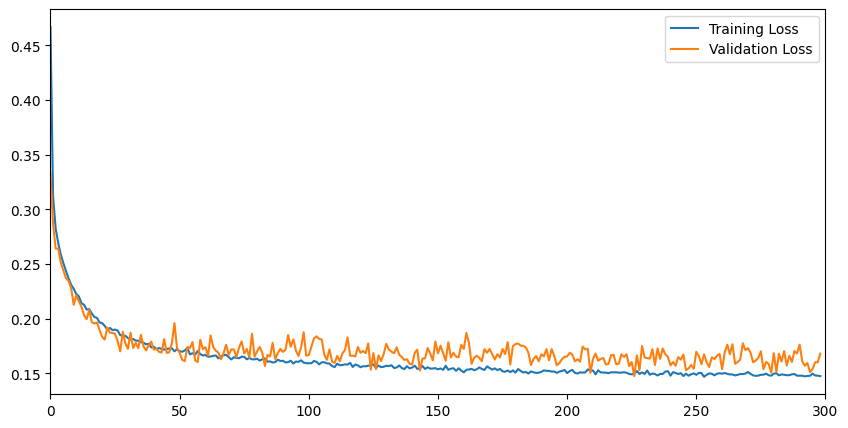

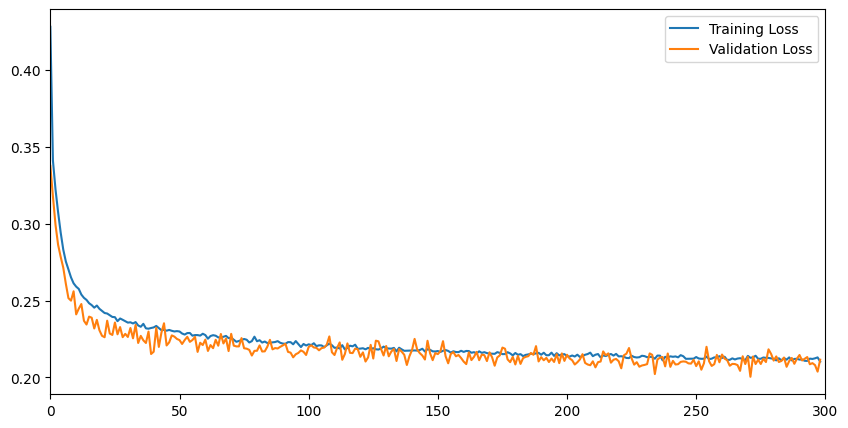

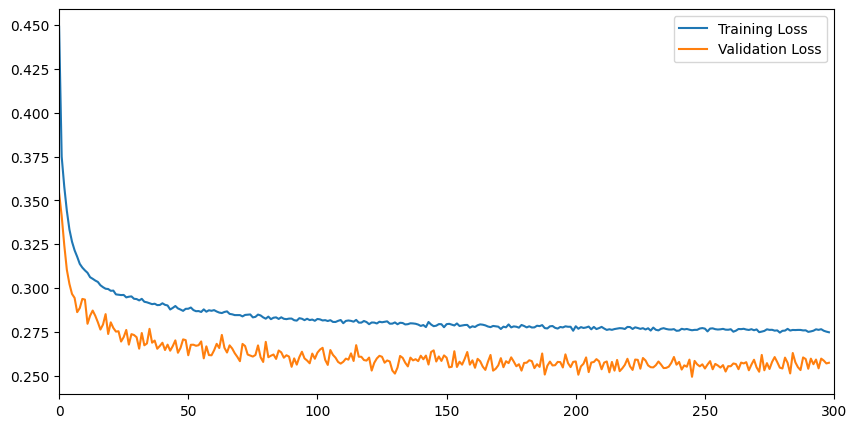

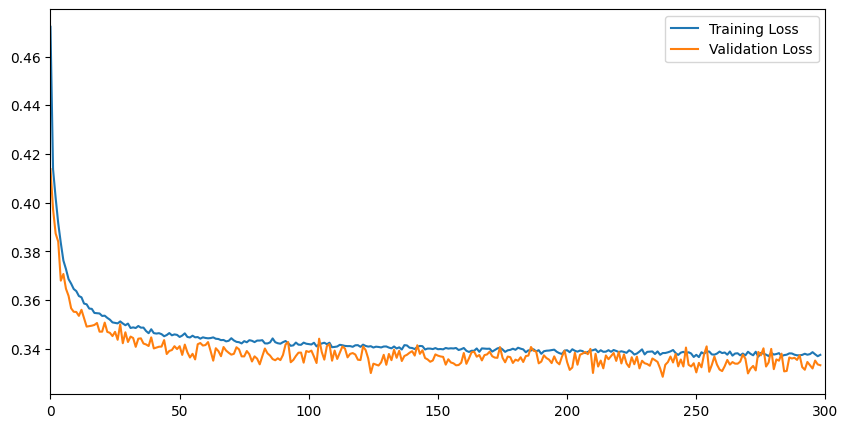

In [100]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=500
save=True

nepochs=300
model_3_6=QuantileNetwork(quantiles=quantiles)
model_10=QuantileNetwork(quantiles=quantiles)
model_25=QuantileNetwork(quantiles=quantiles)
model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
n_nodes=64
sequence=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes,n_nodes),
    nn.ReLU(),
    nn.Linear(n_nodes, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

model_3_6.fit(X_train_3_6.to_numpy(),y_train_3_6.to_numpy(), 
          train_indices_3_6, 
          validation_indices_3_6, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/3_6',model=model_3_6,X_test=X_test_3_6,y_test=y_test_3_6)
    print("Model 3.6 saved...")

model_10.fit(X_train_10.to_numpy(),y_train_10.to_numpy(), 
          train_indices_10, 
          validation_indices_10, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/10',model=model_10,X_test=X_test_10,y_test=y_test_10)
    print("Model 10 saved...")

model_25.fit(X_train_25.to_numpy(),y_train_25.to_numpy(), 
          train_indices_25, 
          validation_indices_25, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:          
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/25',model=model_25,X_test=X_test_25,y_test=y_test_25)
    print("Model 25 saved...")

model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)
if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/all',model=model,X_test=X_test,y_test=y_test)
    print("Model all saved...")

In [137]:
preds = model.predict(X_test.to_numpy())
mse=mean_squared_error(y_test.to_numpy(),preds[:,:,1])
psnr=QuantileNetwork.PSNR(y_test,preds[:,:,1])
quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds)
r2=r2_score(y_test.to_numpy(),preds[:,:,1])

In [138]:
print("MSE: "+str(mse))
print("PSNR: "+str(psnr))
print("Quant_rate: "+str(quant_rate))
print("R2 score: "+str(r2))

MSE: 0.01364196511049075
PSNR: 18.54092045334933
Quant_rate: [0.0844     0.47973333 0.8812    ]
R2 score: 0.6338210450178339


## Load trained models and Visualise

In [117]:
#Load models
model_3_6,X_test_3_6,y_test_3_6=hf.load_model_and_test_data('pytorch_models/test_COT_limits/3_6')
model_10,X_test_10,y_test_10=hf.load_model_and_test_data('pytorch_models/test_COT_limits/10')
model_25,X_test_25,y_test_25=hf.load_model_and_test_data('pytorch_models/test_COT_limits/25')
model,X_test,y_test=hf.load_model_and_test_data('pytorch_models/test_COT_limits/all')

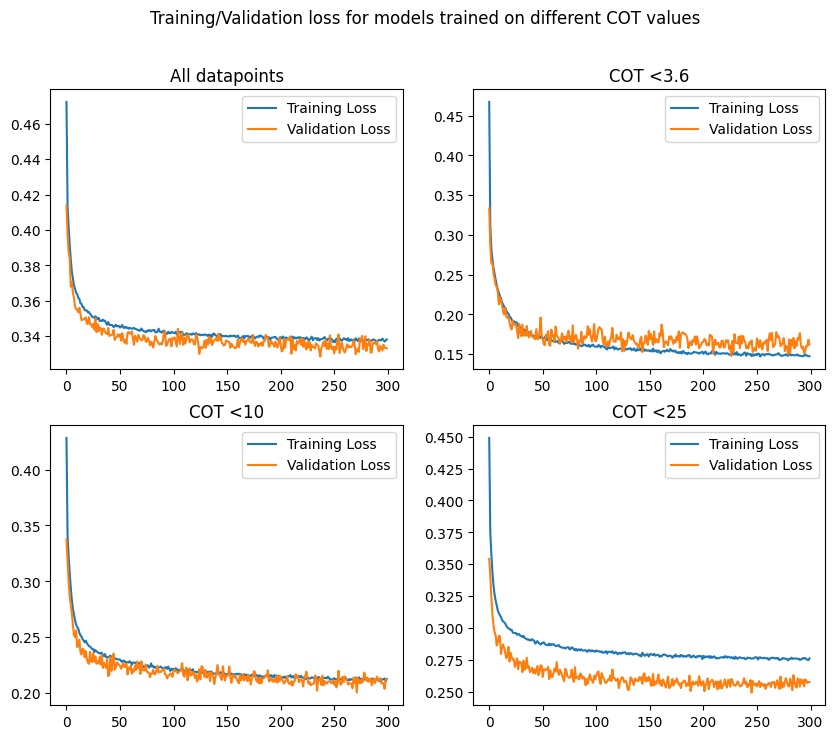

In [118]:
plt.rcParams["figure.figsize"] = [10, 8]
fig, ax =plt.subplots(nrows=2,ncols=2)
fig.suptitle("Training/Validation loss for models trained on different COT values")

ax[0,0].plot(model.train_loss.data.cpu().numpy())
ax[0,0].plot(model.val_loss.data.cpu().numpy())
ax[0,0].set_title("All datapoints")
ax[0,0].legend(['Training Loss','Validation Loss'])

ax[0,1].plot(model_3_6.train_loss.data.cpu().numpy())
ax[0,1].plot(model_3_6.val_loss.data.cpu().numpy())
ax[0,1].set_title("COT <3.6")
ax[0,1].legend(['Training Loss','Validation Loss'])

ax[1,0].plot(model_10.train_loss.data.cpu().numpy())
ax[1,0].plot(model_10.val_loss.data.cpu().numpy())
ax[1,0].set_title("COT <10")
ax[1,0].legend(['Training Loss','Validation Loss'])

ax[1,1].plot(model_25.train_loss.data.cpu().numpy())
ax[1,1].plot(model_25.val_loss.data.cpu().numpy())
ax[1,1].set_title("COT <25")
ax[1,1].legend(['Training Loss','Validation Loss'])

In [119]:
#Make predictions
y_preds_all=model.predict(X_test.to_numpy())
y_preds_3_6=model.predict(X_test_3_6.to_numpy())
y_preds_10=model.predict(X_test_10.to_numpy())
y_preds_25=model.predict(X_test_25.to_numpy())

In [120]:
## Calculate residuals
y_all=y_test.to_numpy()[:,0]
y_pred_all=y_preds_all[:,0,:]
res_all=y_all-y_pred_all[:,1]

y_3_6=y_test_3_6.to_numpy()[:,0]
y_pred_3_6=y_preds_3_6[:,0,:]
res_3_6=y_3_6-y_pred_3_6[:,1]

y_10=y_test_10.to_numpy()[:,0]
y_pred_10=y_preds_10[:,0,:]
res_10=y_10-y_pred_10[:,1]

y_25=y_test_25.to_numpy()[:,0]
y_pred_25=y_preds_25[:,0,:]
res_25=y_25-y_pred_25[:,1]


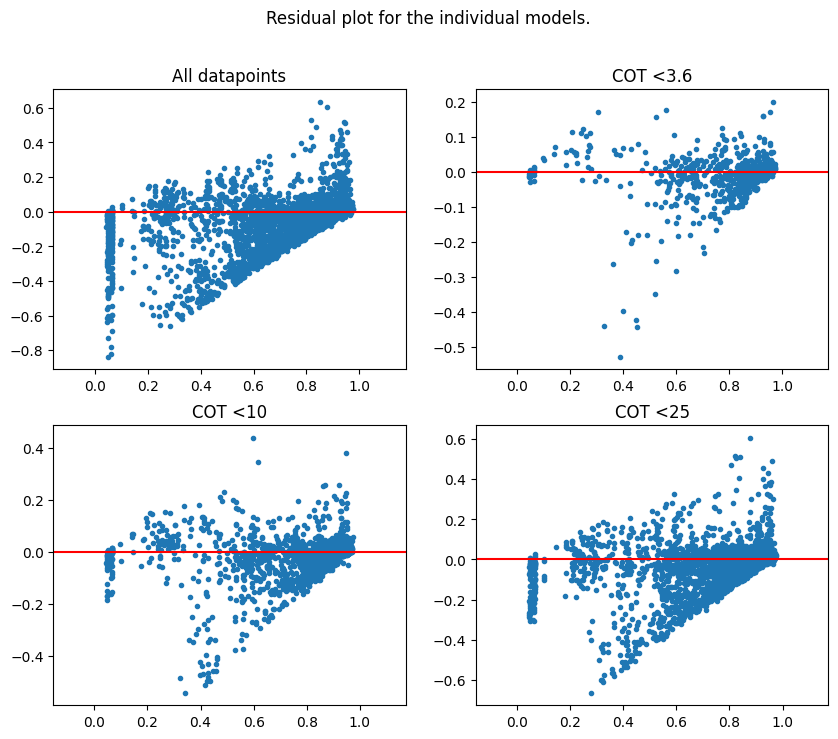

In [121]:
#Plot residuals
fig, ax =plt.subplots(nrows=2,ncols=2)
fig.suptitle("Residual plot for the individual models.")

ax[0,0].plot(y_all,res_all,'.')
ax[0,0].set_title("All datapoints")
ax[0,0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0,0].set_xlim((np.min(y_all)-0.2,np.max(y_all)+0.2))

ax[0,1].plot(y_3_6,res_3_6,'.')
ax[0,1].set_title("COT <3.6")
ax[0,1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0,1].set_xlim((np.min(y_3_6)-0.2,np.max(y_3_6)+0.2))

ax[1,0].plot(y_10,res_10,'.')
ax[1,0].set_title("COT <10")
ax[1,0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1,0].set_xlim((np.min(y_10)-0.2,np.max(y_10)+0.2))

ax[1,1].plot(y_25,res_25,'.')
ax[1,1].set_title("COT <25")
ax[1,1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1,1].set_xlim((np.min(y_10)-0.2,np.max(y_10)+0.2))

plt.show()


### Residual comparison model trained on all vs model trained on COT <3.6

In [122]:
df_3_6=data_all[data_all['COT']<3.6]
df_X_3_6=df_3_6[X_labels]
df_y_3_6=df_3_6[y_labels]

preds=model.predict(df_X_3_6.to_numpy())
preds_3_6=model_3_6.predict(df_X_3_6.to_numpy())


In [123]:
#Calculate residuals
y_all=df_y_3_6.to_numpy()[:,0]
y_pred_all=preds[:,0,:]
res_all=y_all-y_pred_all[:,1]

y_3_6=df_y_3_6.to_numpy()[:,0]
y_pred_3_6=preds_3_6[:,0,:]
res_3_6=y_3_6-y_pred_3_6[:,1]

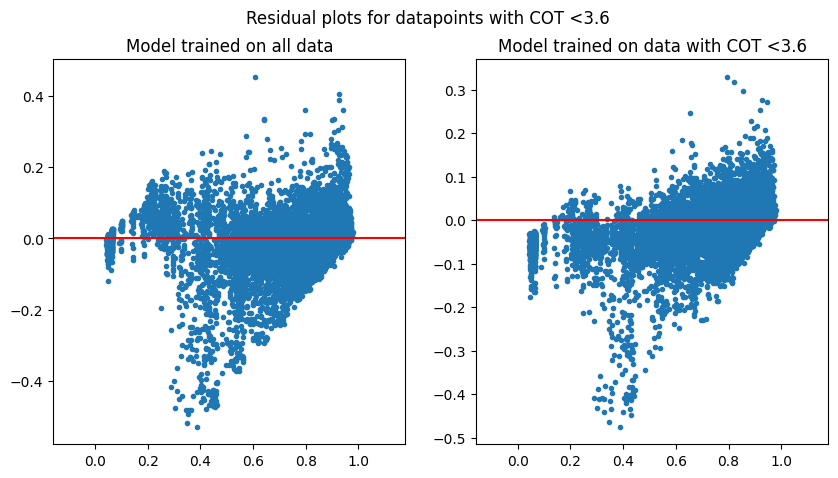

In [124]:
plt.rcParams["figure.figsize"] = [10, 5]
#Plot residuals
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Residual plots for datapoints with COT <3.6")

ax[0].plot(y_all,res_all,'.')
ax[0].set_title("Model trained on all data")
ax[0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0].set_xlim((np.min(y_all)-0.2,np.max(y_all)+0.2))

ax[1].plot(y_3_6,res_3_6,'.')
ax[1].set_title("Model trained on data with COT <3.6")
ax[1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1].set_xlim((np.min(y_3_6)-0.2,np.max(y_3_6)+0.2))

plt.show()

In [125]:
r2_all=r2_score(df_y_3_6.to_numpy(),preds[:,:,1])
r2_3_6=r2_score(df_y_3_6.to_numpy(),preds_3_6[:,:,1])
mse_all=mean_squared_error(df_y_3_6.to_numpy(),preds[:,:,1])
mse_3_6=mean_squared_error(df_y_3_6.to_numpy(),preds_3_6[:,:,1])
print("R2 score for model trained on all data: "+str(r2_all))
print("R2 score for model trained on data with COT <3.6: "+str(r2_3_6))
print(" ")
print("MSE for model trained on all data: "+str(mse_all))
print("MSE for model trained on data with COT <3.6: "+str(mse_3_6))

R2 score for model trained on all data: 0.9114367918167856
R2 score for model trained on data with COT <3.6: 0.9462656201007523
 
MSE for model trained on all data: 0.0032327864364836536
MSE for model trained on data with COT <3.6: 0.0019614440135432196


#### Attempt only test data with COT <3.6

In [126]:
X_test_all_3_6=df.iloc[X_test.index][df.iloc[X_test.index]['COT']<3.6]
X_test_all_3_6=X_test_all_3_6[X_labels]

y_test_all_3_6=df.iloc[X_test.index][df.iloc[X_test.index]['COT']<3.6]
y_test_all_3_6=y_test_all_3_6[y_labels]

preds=model.predict(X_test_all_3_6.to_numpy())
preds_3_6=model_3_6.predict(X_test_3_6.to_numpy())

In [127]:
#Calculate residuals
y_all=y_test_all_3_6.to_numpy()[:,0]
y_pred_all=preds[:,0,:]
res_all=y_all-y_pred_all[:,1]

y_3_6=y_test_3_6.to_numpy()[:,0]
y_pred_3_6=preds_3_6[:,0,:]
res_3_6=y_3_6-y_pred_3_6[:,1]

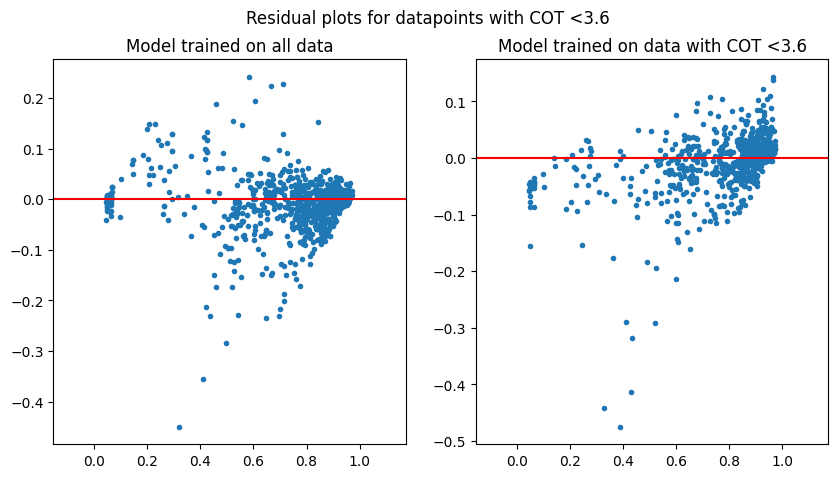

In [128]:
plt.rcParams["figure.figsize"] = [10, 5]
#Plot residuals
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Residual plots for datapoints with COT <3.6")

ax[0].plot(y_all,res_all,'.')
ax[0].set_title("Model trained on all data")
ax[0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0].set_xlim((np.min(y_all)-0.2,np.max(y_all)+0.2))

ax[1].plot(y_3_6,res_3_6,'.')
ax[1].set_title("Model trained on data with COT <3.6")
ax[1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1].set_xlim((np.min(y_3_6)-0.2,np.max(y_3_6)+0.2))

plt.show()

In [131]:
r2_all=r2_score(y_test_all_3_6.to_numpy(),preds[:,:,1])
r2_3_6=r2_score(y_test_3_6.to_numpy(),preds_3_6[:,:,1])
mse_all=mean_squared_error(y_test_all_3_6.to_numpy(),preds[:,:,1])
mse_3_6=mean_squared_error(y_test_3_6.to_numpy(),preds_3_6[:,:,1])
print("R2 score for model trained on all data: "+str(r2_all))
print("R2 score for model trained on data with COT <3.6: "+str(r2_3_6))
print(" ")
print("MSE for model trained on all data: "+str(mse_all))
print("MSE for model trained on data with COT <3.6: "+str(mse_3_6))

R2 score for model trained on all data: 0.9500848781421212
R2 score for model trained on data with COT <3.6: 0.9399534768311123
 
MSE for model trained on all data: 0.001877452382018316
MSE for model trained on data with COT <3.6: 0.0021126013720914826


## Test plot function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_248933/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-01 14:20:37.578935: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 14:20:37.613577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 14:20

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df=data_all.copy()

data_all_3_6=data_all[data_all['COT']<3.6]
data_all_10=data_all[data_all['COT']<10]
data_all_25=data_all[data_all['COT']<25]

In [4]:
#Load models
model_3_6,X_test_3_6,y_test_3_6=hf.load_model_and_test_data('pytorch_models/test_COT_limits/3_6')
model_10,X_test_10,y_test_10=hf.load_model_and_test_data('pytorch_models/test_COT_limits/10')
model_25,X_test_25,y_test_25=hf.load_model_and_test_data('pytorch_models/test_COT_limits/25')
model,X_test,y_test=hf.load_model_and_test_data('pytorch_models/test_COT_limits/all')

In [18]:
df.iloc[X_test_3_6.index]

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,...,Clear_B12,Clear_B13,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor
22828,0.28680,0.27066,0.38420,0.26682,0.48899,0.88662,0.83668,0.90018,0.27914,0.00090,...,0.85514,0.72447,0.04,61.03,55.76,2.939,5,770,0.125,0.89
24910,0.26771,0.30782,0.41308,0.64639,0.84513,0.96548,0.85638,0.99519,0.08496,0.00027,...,0.93695,0.81807,2.03,36.36,72.50,0.005,5,8184,0.124,4.96
11905,0.20818,0.21106,0.36263,0.19556,0.49505,1.01446,0.99274,1.02114,0.60759,0.01421,...,0.96187,0.89330,11.00,43.22,36.38,0.156,1,3248,0.105,0.36
13549,0.27545,0.24287,0.31570,0.24544,0.39259,0.77152,0.74521,0.77934,0.36656,0.00631,...,0.77312,0.64177,1.19,70.72,150.86,3.274,3,3814,0.122,0.40
31716,0.98025,0.91805,0.96220,0.93384,0.96454,0.99076,0.91945,1.00764,0.45675,0.03615,...,0.94989,0.90996,13.84,45.70,133.31,21.064,2,1807,0.122,1.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32535,0.57666,0.52510,0.56537,0.51630,0.59164,0.78955,0.66564,0.82874,0.10148,0.00035,...,0.90011,0.70904,14.23,66.04,167.66,22.405,5,8732,0.129,6.29
47702,0.28679,0.24323,0.31824,0.21813,0.38032,0.72869,0.63347,0.75660,0.06069,0.00066,...,0.89919,0.74577,11.07,73.77,110.32,1.606,2,6099,0.125,3.41
9663,0.26172,0.19906,0.19726,0.17388,0.19154,0.21177,0.17522,0.22498,0.00818,0.00068,...,0.24206,0.18399,11.72,79.40,111.18,0.151,4,6909,0.128,4.54
46675,0.40918,0.38241,0.44331,0.36627,0.54561,0.95101,0.82049,0.99093,0.07307,0.00032,...,0.93041,0.80731,1.46,50.08,119.53,2.888,2,7128,0.128,4.24


In [5]:
y_preds=model.predict(X_test.to_numpy())
y_preds=y_preds[:,0]

y_preds_3_6=model.predict(X_test_3_6.to_numpy())
y_preds_3_6=y_preds_3_6[:,0]

y_preds_10=model.predict(X_test_10.to_numpy())
y_preds_10=y_preds_10[:,0]

y_preds_25=model.predict(X_test_25.to_numpy())
y_preds_25=y_preds_25[:,0]

In [6]:
from functions.plot_metrics import plot_metrics

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/edgelab/filip/SEEX30_Cloud_Fog/SEEX30_Cloud_Fog/Cloud_rm/functions/plot_metrics.py:173: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(x=np.linspace(0,len(y_pred_sort_samp[i][:,1]),len(y_pred_sort_samp[i][:,1]))


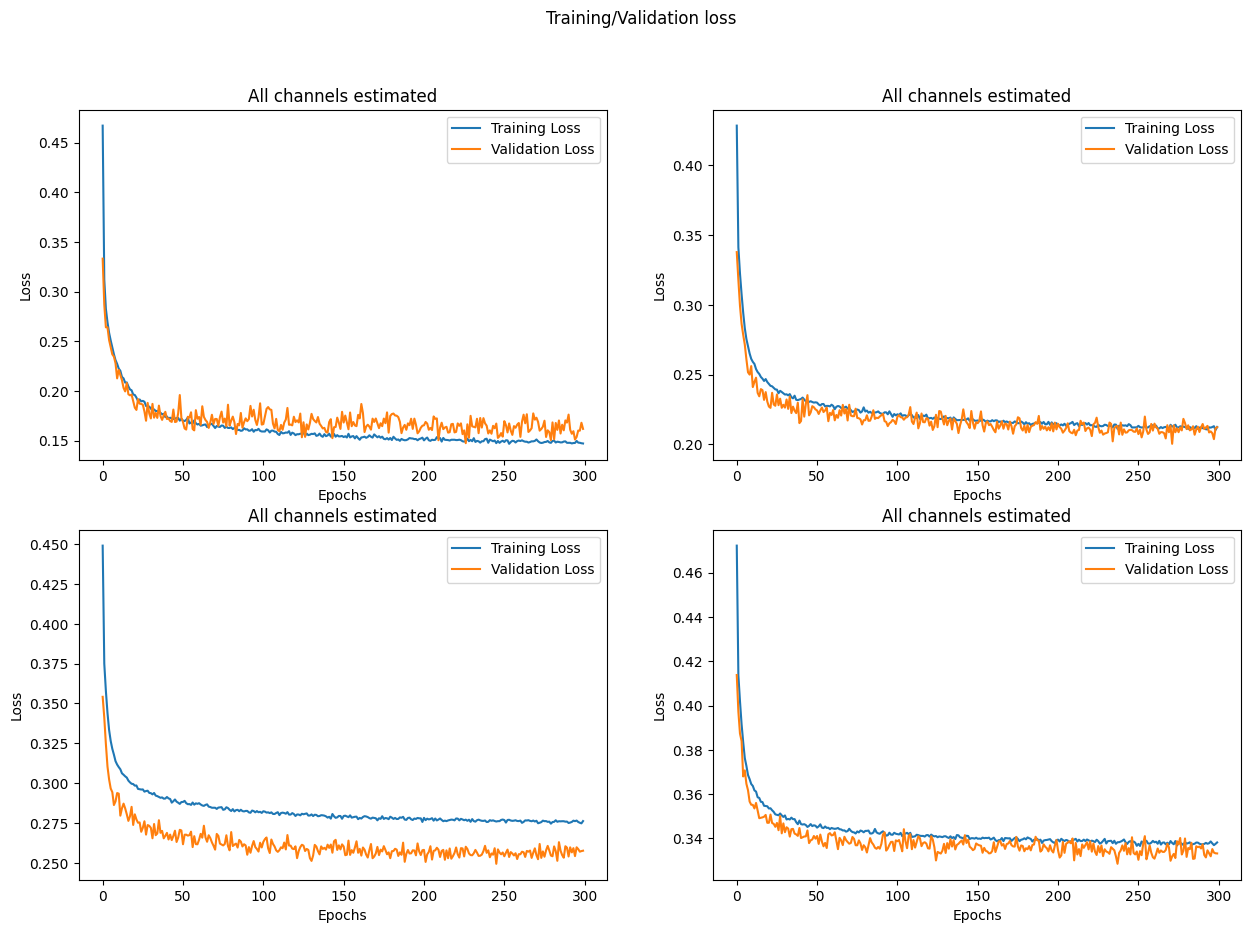

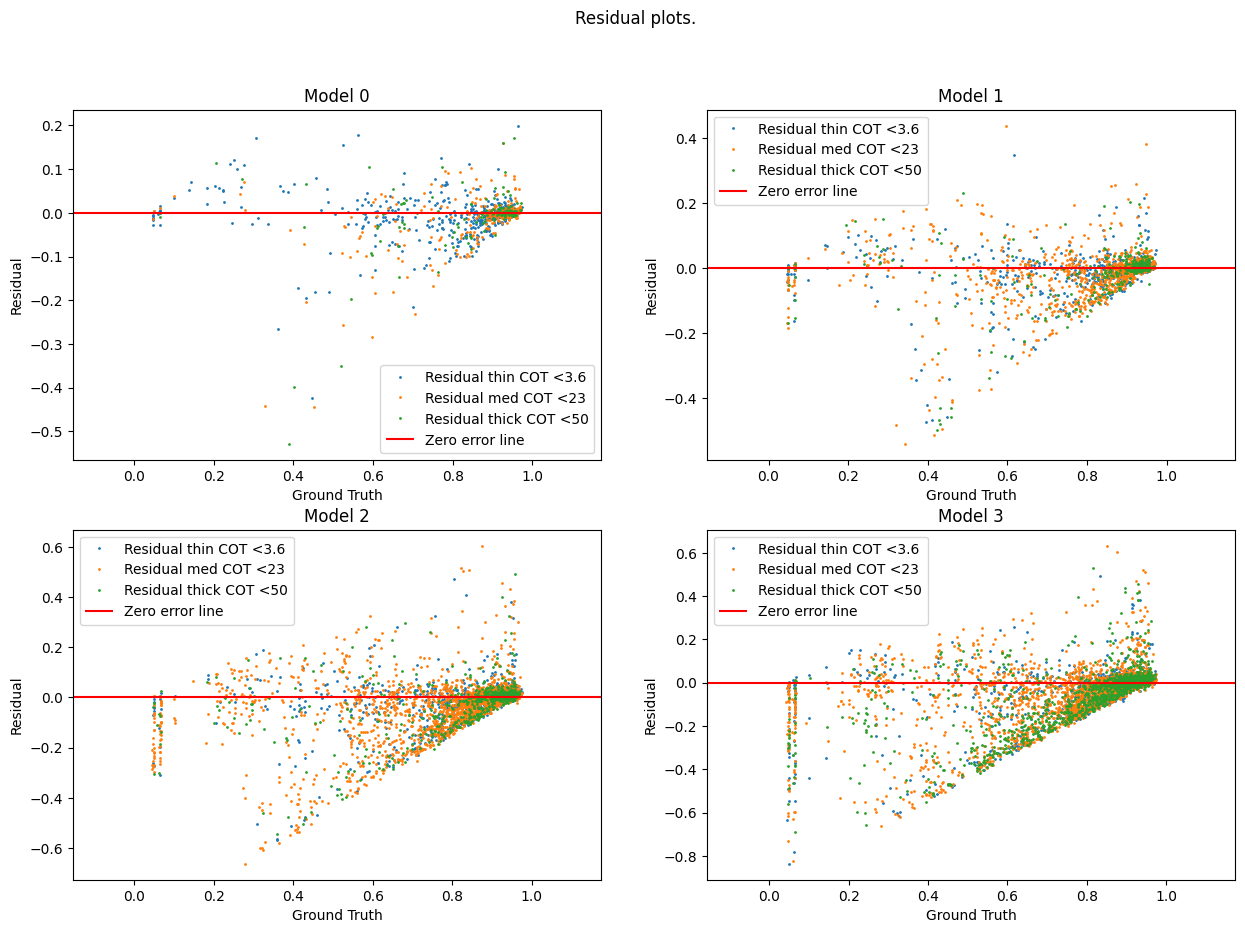

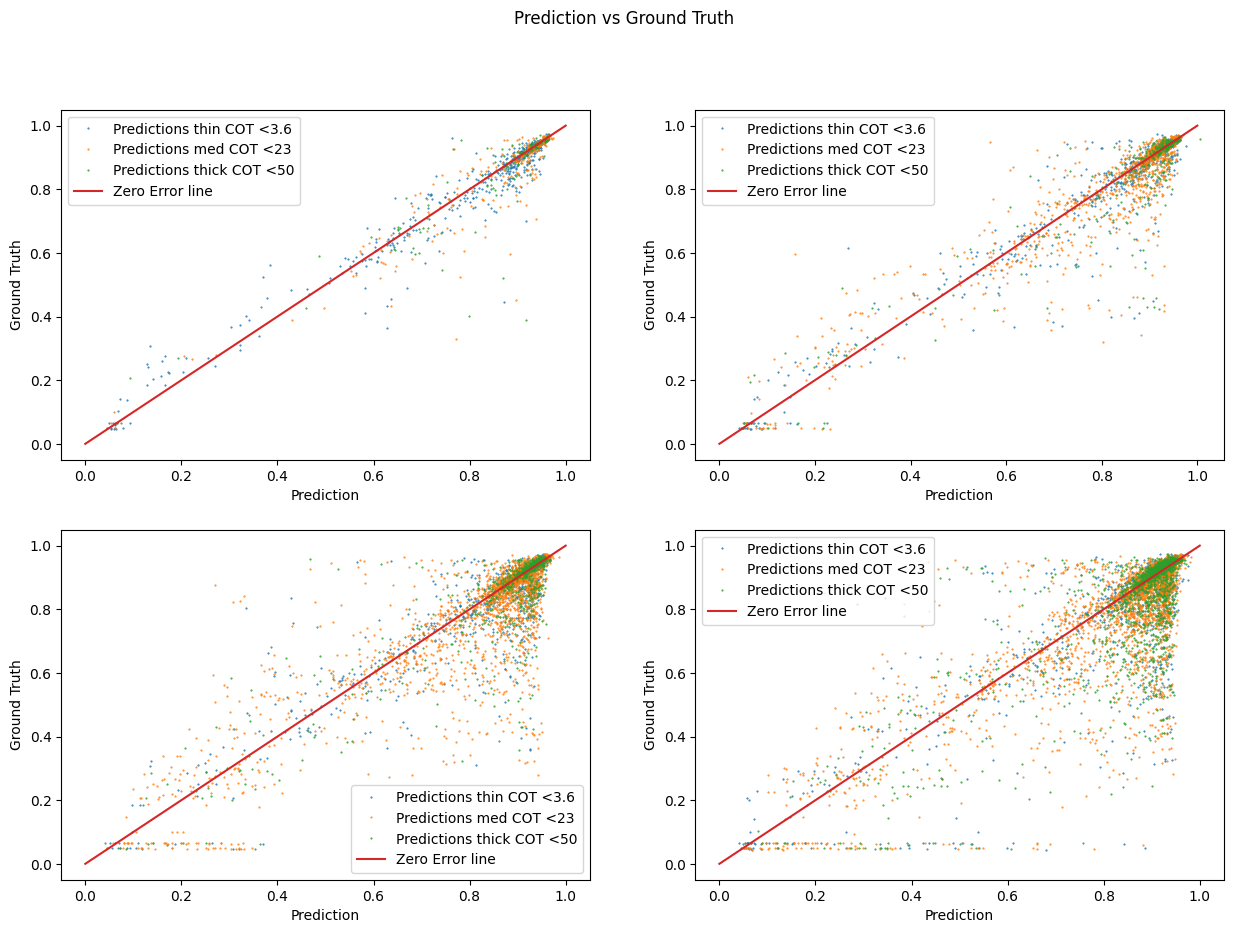

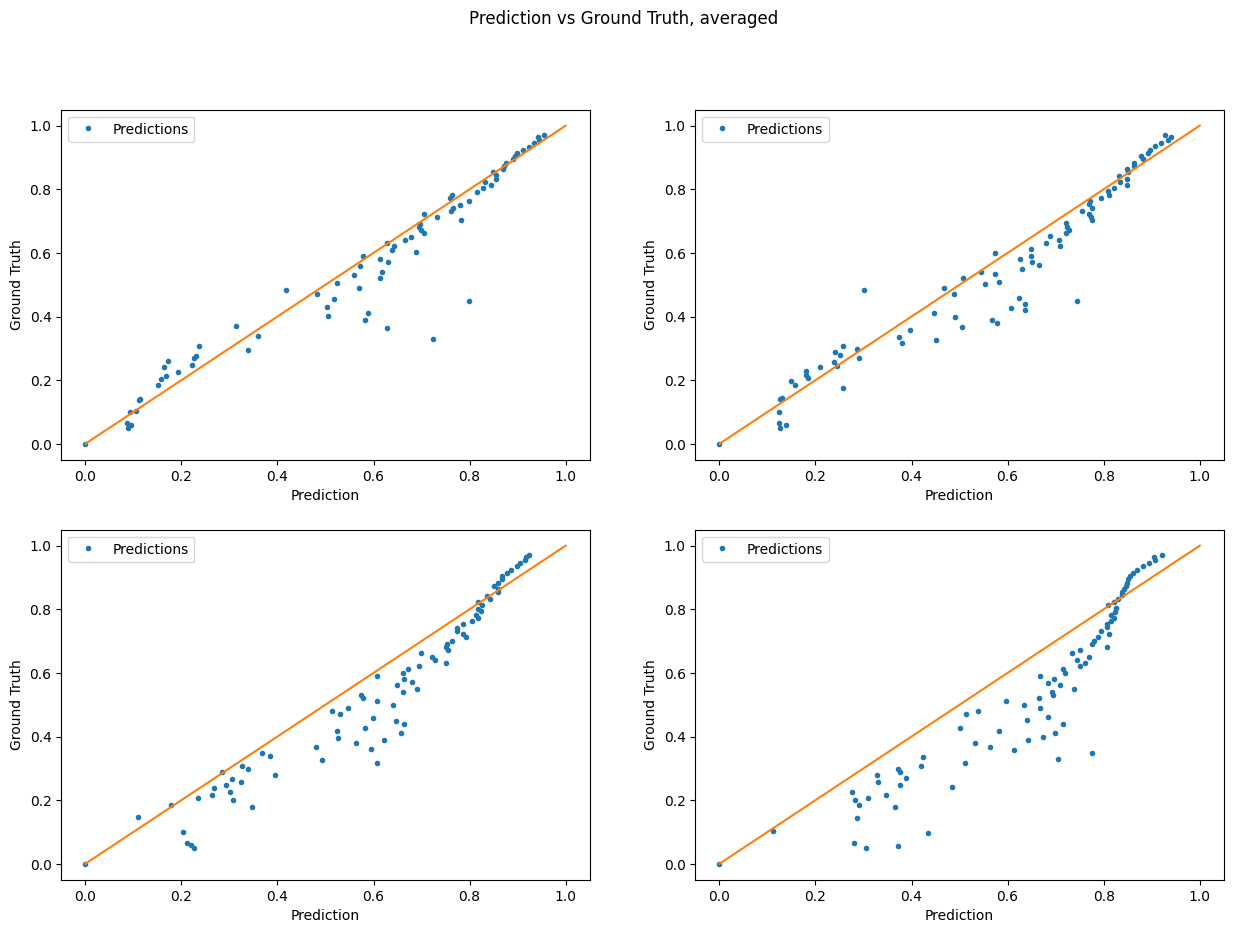

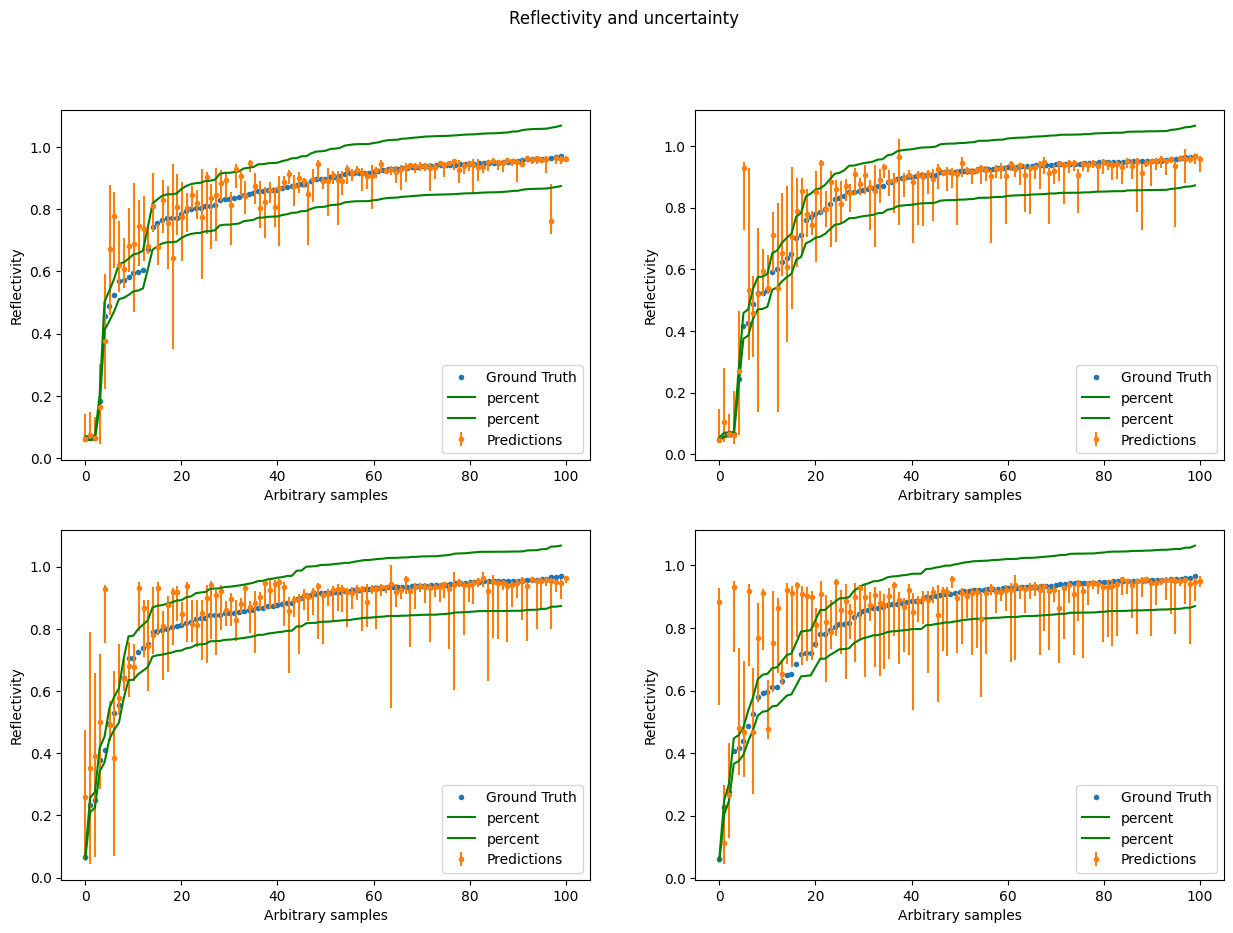

In [12]:
plt.rcParams["figure.figsize"] = [15, 10]
figs,axs,mses,r2s,psnrs,quantrates,quantcrosses = plot_metrics([model_3_6,model_10,model_25,model],
                                                                [X_test_3_6,X_test_10,X_test_25,X_test],
                                                                [y_test_3_6,y_test_10,y_test_25,y_test],
                                                                [y_preds_3_6,y_preds_10,y_preds_25,y_preds],
                                                                df,
                                                                samples=100,
                                                                nrows=2,
                                                                ncols=2)

In [8]:
for i,mse in enumerate(mses):
    print("MSE for model "+str(i)+': '+str(mse))
print(" ")
for i,r2 in enumerate(r2s):
    print("R2 score for model "+str(i)+': '+str(r2))
print(" ")
for i,psnr in enumerate(psnrs):
    print("PSNR for model "+str(i)+': '+str(psnr))
print(" ")
for i,quantrate in enumerate(quantrates):
    print("Quantrate for model "+str(i)+': '+str(quantrate))
print(" ")
for i,quantcross in enumerate(quantcrosses):
    print("Quantile crossing for model "+str(i)+': '+str(quantcross))

MSE for model 0: 0.003027357801161565
MSE for model 1: 0.0051914603470406325
MSE for model 2: 0.00894634013246946
MSE for model 3: 0.01364196511049075
 
R2 score for model 0: 0.9139533313054722
R2 score for model 1: 0.8691259812035574
R2 score for model 2: 0.7394436468998047
R2 score for model 3: 0.6338210450178339
 
PSNR for model 0: 25.069598089975422
PSNR for model 1: 22.726670499553812
PSNR for model 2: 20.37452740308003
PSNR for model 3: 18.54092045334933
 
Quantrate for model 0: [0.06605505 0.57798165 0.96146789]
Quantrate for model 1: [0.06245297 0.52370203 0.94394281]
Quantrate for model 2: [0.07606352 0.49970594 0.90648892]
Quantrate for model 3: [0.0844     0.47973333 0.8812    ]
 
Quantile crossing for model 0: 0.0
Quantile crossing for model 1: 0.0
Quantile crossing for model 2: 0.0
Quantile crossing for model 3: 0.0


In [9]:
model_3_6.val_loss

tensor([0.3332, 0.2869, 0.2641, 0.2641, 0.2513, 0.2442, 0.2369, 0.2346, 0.2280,
        0.2127, 0.2212, 0.2159, 0.2109, 0.2031, 0.1996, 0.2080, 0.1967, 0.1956,
        0.1964, 0.1899, 0.1833, 0.1810, 0.1919, 0.1873, 0.1870, 0.1862, 0.1794,
        0.1701, 0.1880, 0.1774, 0.1724, 0.1871, 0.1732, 0.1779, 0.1729, 0.1853,
        0.1748, 0.1709, 0.1754, 0.1791, 0.1718, 0.1724, 0.1698, 0.1689, 0.1813,
        0.1688, 0.1693, 0.1775, 0.1959, 0.1728, 0.1688, 0.1623, 0.1612, 0.1741,
        0.1732, 0.1786, 0.1618, 0.1604, 0.1807, 0.1721, 0.1739, 0.1660, 0.1846,
        0.1740, 0.1708, 0.1689, 0.1629, 0.1684, 0.1761, 0.1668, 0.1719, 0.1719,
        0.1649, 0.1737, 0.1793, 0.1682, 0.1723, 0.1644, 0.1862, 0.1652, 0.1702,
        0.1742, 0.1686, 0.1567, 0.1668, 0.1654, 0.1779, 0.1631, 0.1685, 0.1725,
        0.1697, 0.1717, 0.1850, 0.1743, 0.1812, 0.1709, 0.1658, 0.1736, 0.1876,
        0.1662, 0.1667, 0.1743, 0.1820, 0.1839, 0.1815, 0.1810, 0.1671, 0.1623,
        0.1720, 0.1607, 0.1595, 0.1659, 